In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import numpy as np
import pandas as pd
import openslide
from PIL import Image
from tqdm import tqdm
import scanpy as sc
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import cm


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---------------------------------------------------------------------
# Define parameters
# ---------------------------------------------------------------------
cancer = "breast"          # {lung, breast, …}
ground_truth = "refined"      # dataset variant
checkpoint = "latest"  # best or latest
level = 0               # centre‑token level (0 or 1 here)
batch_size = 72
num_workers = 8               # DataLoader workers (tune to CPU cores)
proj_dim = 128             # dimension of joint embedding space

In [7]:
#  ---- paths ---------------------------------------------------------
xenium_sample_dict = {
    "lung":       "Xenium_Prime_Human_Lung_Cancer_FFPE_outs",
    "breast":     "Xenium_Prime_Breast_Cancer_FFPE_outs",
    "lymph_node": "Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs",
    "prostate":   "Xenium_Prime_Human_Prostate_FFPE_outs",
    "skin":       "Xenium_Prime_Human_Skin_FFPE_outs",
    "ovarian":    "Xenium_Prime_Ovarian_Cancer_FFPE_outs",
    "cervical":   "Xenium_Prime_Cervical_Cancer_FFPE_outs",
}
data_root   = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics"
embedding_root = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings"
xenium_sample  = xenium_sample_dict[cancer]
adata_path = f"{data_root}/{xenium_sample}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_v2_annotated.h5ad"
emb_path  = f"{embedding_root}/public_data/{xenium_sample}/scGPT_CP.h5ad"
slide_path= f"{data_root}/{xenium_sample}/{xenium_sample.rsplit('_',1)[0]}_he_image_registered.ome.tif" 
emb_save_dir = f"{embedding_root}/public_data/{xenium_sample}/contrastive_learning/level_{level}"
os.makedirs(emb_save_dir, exist_ok=True)
# ---------------------------------------------------------------------
# Load cell metadata & gene embeddings (fixed)
# ---------------------------------------------------------------------
adata = sc.read_h5ad(adata_path)
cell_df = adata.obs                     # index = cell IDs
  
gdata = sc.read_h5ad(emb_path)
gene_emb = pd.DataFrame(gdata.obsm["X_scGPT"], index=cell_df.index)

print("Cells:", cell_df.shape[0])
print("Gene‑embedding dim:", gene_emb.shape[1])

# ---------------------------------------------------------------------
# Slide info (MPP)
# ---------------------------------------------------------------------
slide = openslide.open_slide(slide_path)
mpp_x = float(slide.properties.get("openslide.comment").split('PhysicalSizeX="')[1].split('"')[0])
current_mpp= mpp_x
print("Slide MPP:", current_mpp)

# ---------------------------------------------------------------------
# Torch vision transform for UNI2
# ---------------------------------------------------------------------
patch_size = 224
transform = transforms.Compose([
    transforms.Resize((patch_size, patch_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

target_mpp = 0.5  # 20×
scale = target_mpp / current_mpp

# ---------------------------------------------------------------------
# Dataset with on‑the‑fly patch extraction
# ---------------------------------------------------------------------
class CellPatchDataset(Dataset):
    def __init__(self, slide, cell_df, transform, scale, patch_size):
        self.slide      = slide
        self.cells      = cell_df.reset_index(drop=False)  # keep cell IDs
        self.tfm        = transform
        self.scale      = scale
        self.patch_size = patch_size

    def __len__(self):
        return len(self.cells)

    def _read_patch(self, x, y):
        big = int(self.patch_size * self.scale)
        tlx, tly = int(x - big/2), int(y - big/2)
        patch = self.slide.read_region((tlx, tly), 0, (big, big)).convert("RGB")
        return patch.resize((self.patch_size, self.patch_size), Image.LANCZOS)

    def __getitem__(self, idx):
        row = self.cells.iloc[idx]
        patch = self._read_patch(row.x_centroid, row.y_centroid)
        img_t = self.tfm(patch)
        return img_t, idx

# ---------------------------------------------------------------------
# DataLoader with prefetching
# ---------------------------------------------------------------------
dataloader = DataLoader(
    CellPatchDataset(slide, cell_df, transform, scale, patch_size),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

Cells: 461094
Gene‑embedding dim: 512
Slide MPP: 0.2125


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_dir = "/rsrch5/home/plm/phacosta/models/fine_tuned/UNI2/finetuned_uni2_contrastive"

if checkpoint == "best":
    ckpt_name = "best.pth"
    print("Using best epoch")
else:
    ckpt_list = glob(os.path.join(ckpt_dir,"epoch_*"))
    epochs = [np.uint8(os.path.basename(ep).rsplit("_")[1].rsplit(".")[0]) for ep in ckpt_list]
    latest_epoch = np.max(epochs)
    if latest_epoch<=9:
        ckpt_name = f"epoch_00{latest_epoch}.pth"
    else:
        ckpt_name = f"epoch_0{latest_epoch}.pth"
    print("Using epoch:", ckpt_name)
          
uni2_cfg = {
    'model_name':'vit_giant_patch14_224','img_size':224,'patch_size':14,'depth':24,
    'num_heads':24,'init_values':1e-5,'embed_dim':1536,'mlp_ratio':2.66667*2,
    'num_classes':0,'no_embed_class':True,'mlp_layer':timm.layers.SwiGLUPacked,
    'act_layer':torch.nn.SiLU,'reg_tokens':8,'dynamic_img_size':True
}

class Projection(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(in_dim,256), nn.ReLU(), nn.Linear(256,out_dim))
    def forward(self,x):
        return self.mlp(x)

# ‑‑ load best checkpoint you just trained
ckpt = torch.load(f"{ckpt_dir}/{ckpt_name}", map_location=device)
model = timm.create_model(pretrained=False, **uni2_cfg).to(device)
model.load_state_dict(ckpt["model"])
model.eval()

prefix_tokens = getattr(model, "num_prefix_tokens", 9)  # fallback reg_tokens + cls 
level_idx_map = {
    0: torch.tensor([119,120,135,136]),
    1: torch.tensor([102,103,104,105,118,119,120,121,134,135,136,137,150,151,152,153])}
idx_center = level_idx_map[level].to(device)


proj_gene = Projection(gene_emb.shape[1], proj_dim).to(device)
proj_morph = Projection(1536, proj_dim).to(device)
proj_gene.load_state_dict(ckpt["proj_gene"]);    
proj_morph.load_state_dict(ckpt["proj_morph"]);  
proj_gene.eval()
proj_morph.eval()

Using epoch: epoch_020.pth


Projection(
  (mlp): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [9]:
joint_list  = []          # 128‑D (proj space)
morph_list  = []          # 1536‑D (UNI2 backbone)
cell_ids    = []

model.eval(); proj_gene.eval(); proj_morph.eval()
with torch.no_grad():
    for imgs, idx_batch in tqdm(dataloader, desc="Extract embeddings"):
        imgs   = imgs.to(device, non_blocking=True)
        idx_np = idx_batch.cpu().numpy()
        cell_ids.extend(cell_df.index[idx_np])

        # ---- UNI2 forward --------------------------------------------------
        tokens  = model.forward_features(imgs)                 # (B,265,1536)
        spatial = tokens[:, prefix_tokens:, :]                 # drop prefixes
        center  = spatial[:, idx_center, :].mean(1)            # (B,1536)

        # ---- morphology‑only embedding ------------------------------------
        morph_list.append(center.cpu())                        # keep 1536‑D

        # ---- projection heads for contrastive emb -------------------------
        morph_proj = proj_morph(center)                        # (B,128)
        gene_proj  = proj_gene(
            torch.as_tensor(
                gene_emb.iloc[idx_np].values, dtype=torch.float32,
            ).to(device, non_blocking=True)
        )                                                      # (B,128)

        joint_emb = 0.5 * (morph_proj + gene_proj)             # (B,128)
        joint_list.append(joint_emb.cpu())

# --------------------------------------------------------------------------
# Concatenate and save
# --------------------------------------------------------------------------
morph_arr  = torch.cat(morph_list).numpy()     # (N_cells,1536)
joint_arr  = torch.cat(joint_list).numpy()     # (N_cells,128)

ckpt_emb = ckpt_name.rsplit(".")[0]
pd.DataFrame(morph_arr, index=cell_ids).to_csv(os.path.join(emb_save_dir,f"uni2_finetuned_{ckpt_emb}_embeddings.csv"))
pd.DataFrame(joint_arr,  index=cell_ids).to_csv(os.path.join(emb_save_dir,f"joint_finetuned_{ckpt_emb}_embeddings.csv"))
print("✓ Saved morphology‑only and joint contrastive embeddings")


Extract embeddings: 100%|██████████| 6405/6405 [1:02:57<00:00,  1.70it/s]


✓ Saved morphology‑only and joint contrastive embeddings


2025-04-17 20:49:22.436753: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 20:49:22.451773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 20:49:22.469931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 20:49:22.469965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 20:49:22.483295: I tensorflow/core/platform/cpu_feature_gua

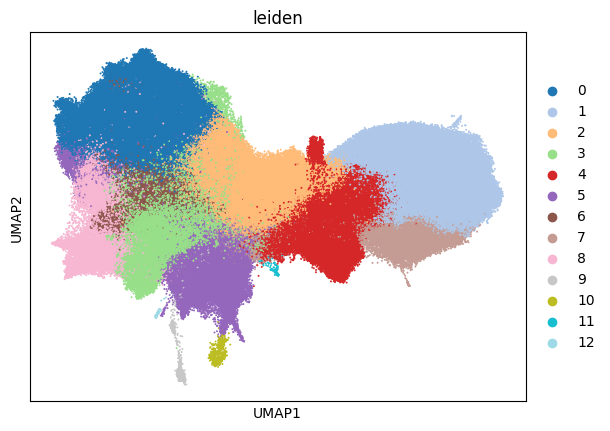

morph:  n_clusters = 13


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
/tmp/ipykernel_42308/30628162.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab20", clusters.nunique())


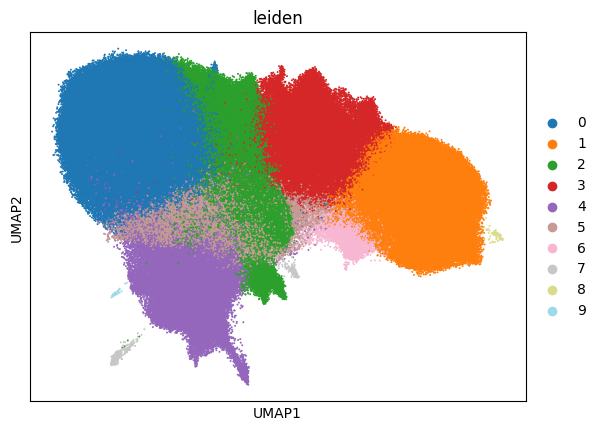

joint:  n_clusters = 10


In [11]:

def cluster_and_plot(csv_path, out_prefix, n_neighbors=15, res=0.5):
    X  = pd.read_csv(csv_path, index_col=0)
    ad = sc.AnnData(X.values, obs=pd.DataFrame(index=X.index))
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep='X')
    sc.tl.umap(ad)
    sc.tl.leiden(ad, resolution=res)

    # enforce numeric ordering and assign tab20 colors
    clusters = ad.obs['leiden'].astype(int)
    ad.obs['leiden'] = clusters.astype(str)
    palette = cm.get_cmap("tab20", clusters.nunique())
    colors = [palette(i) for i in range(clusters.nunique())]
    ad.uns['leiden_colors'] = [f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
                               for r,g,b,_ in colors]

    sc.pl.umap(ad, color='leiden', size=8)
    print(f"{out_prefix}:  n_clusters = {clusters.nunique()}")
    return ad
    
morph_ad  = cluster_and_plot(os.path.join(emb_save_dir,f"uni2_finetuned_{ckpt_emb}_embeddings.csv"), "morph",  n_neighbors=15, res=0.5)
joint_ad  = cluster_and_plot(os.path.join(emb_save_dir,f"joint_finetuned_{ckpt_emb}_embeddings.csv"), "joint",  n_neighbors=15, res=0.5)


/tmp/ipykernel_42308/3652481982.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_colors)   # fresh copy each call


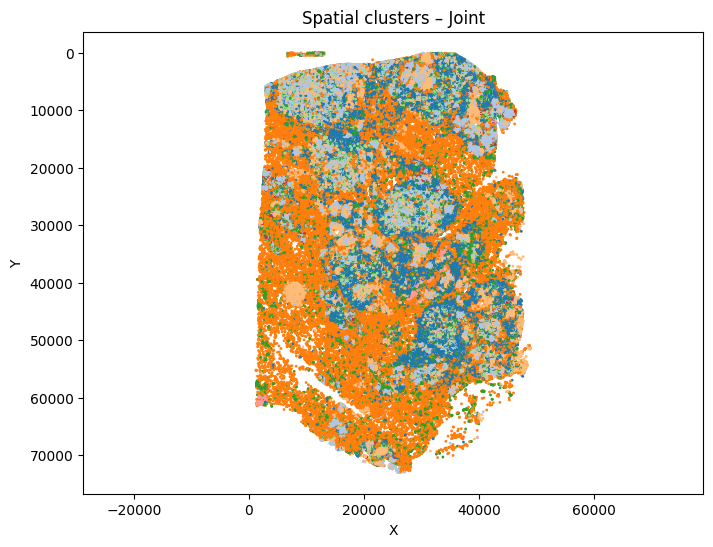

In [12]:

def plot_spatial_clusters(adata, spatial_df, title, cmap_name="tab20", n_colors=20):
    """Scatter clusters in slide‑pixel space."""
    # add coords (cheap; overwrites if they already exist)
    adata.obs['x'] = spatial_df.loc[adata.obs_names, 'x']
    adata.obs['y'] = spatial_df.loc[adata.obs_names, 'y']

    cmap = plt.cm.get_cmap(cmap_name, n_colors)   # fresh copy each call

    plt.figure(figsize=(8, 6))
    plt.scatter(
        adata.obs['x'], adata.obs['y'],
        c=adata.obs['leiden'].astype(int),
        cmap=cmap, s=1, vmin=0, vmax=n_colors-1   # fixed mapping
    )
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    plt.xlabel('X'); plt.ylabel('Y')
    plt.show()

# ------------------------------------------------------------------
spatial_coords = cell_df[['x_centroid', 'y_centroid']].rename(columns={'x_centroid': 'x', 'y_centroid': 'y'})
plot_spatial_clusters(joint_ad,  spatial_coords, "Spatial clusters – Joint")


/tmp/ipykernel_42308/3652481982.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_colors)   # fresh copy each call


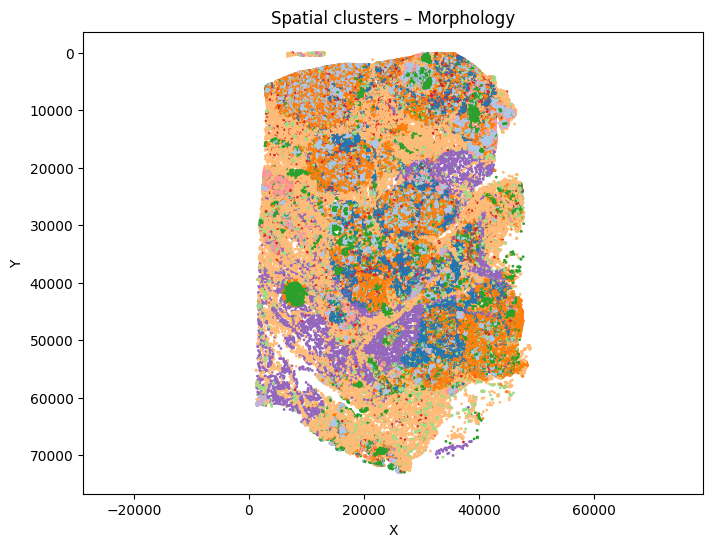

In [13]:
plot_spatial_clusters(morph_ad,  spatial_coords, "Spatial clusters – Morphology")
